In [1]:
import pm4py
import os

bpmn_graph = pm4py.read_bpmn("../configurations/TO-BE-startup-bakery-startup-workflow.bpmn")

In [2]:
from pm4py.objects.conversion.bpmn import converter as bpmn_converter

petri_net, im, fm = bpmn_converter.apply(bpmn_graph)

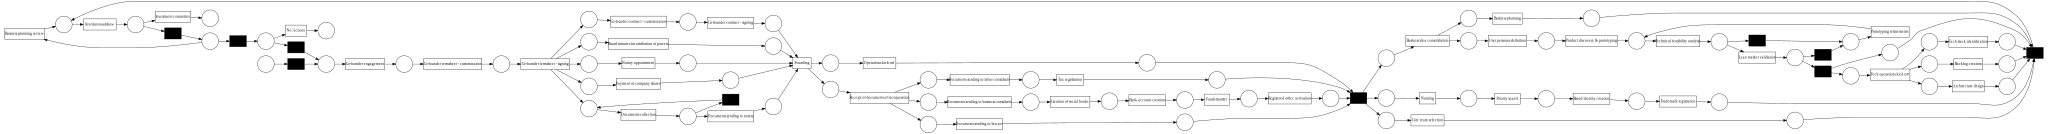

In [3]:
from pm4py.visualization.petri_net import visualizer as petri_visualizer
petri_visualizer.apply(petri_net)

In [4]:
# importing the module
import ast

with open('../configurations/TO-BE-time_constraints.txt', "r") as time_constraints:
    time_constraints = [ast.literal_eval(line) for line in time_constraints][0]

with open('../configurations/TO-BE-antecedents.txt', "r") as antecedents:
    antecedents = [ast.literal_eval(line) for line in antecedents][0]

In [5]:
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.algo.filtering.pandas.attr_value_repetition import filter
from pm4py.objects.conversion.log import converter as log_converter
import pandas as pd

simulated_log = simulator.apply(petri_net, im, variant=simulator.Variants.BASIC_PLAYOUT, parameters={simulator.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: 200, simulator.Variants.BASIC_PLAYOUT.value.Parameters.TIME_CONSTRAINTS:time_constraints, simulator.Variants.BASIC_PLAYOUT.value.Parameters.ANTECEDENTS:antecedents, simulator.Variants.BASIC_PLAYOUT.value.Parameters.RANDOMNESS_OF_TIMESTAMP: 0.2})   
log_csv = log_converter.apply(simulated_log, variant=log_converter.Variants.TO_DATA_FRAME)

#Here we filter out the traces that are supposed to be aletich
valid_traces = filter.apply(log_csv, value = "Co-founder engagement", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 4})
valid_traces = filter.apply(valid_traces, value = "Documents collection", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 4})
valid_traces = filter.apply(valid_traces, value = "Naming", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 4})
valid_traces = filter.apply(valid_traces, value = "Investors roadshow", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 2})
valid_traces = filter.apply(valid_traces, value = "Prototyping refinements", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 3})
valid_traces = filter.apply(valid_traces, value = "Lean market validation", parameters = {filter.Parameters.MIN_REP : 1, filter.Parameters.MAX_REP : 2})

simulated_log = log_converter.apply(valid_traces)

In [6]:
len(simulated_log)

59

In [7]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
dataframe = log_converter.apply(simulated_log, variant=log_converter.Variants.TO_DATA_FRAME)
#dataframe.to_csv('../data/TO-BE-valid_traces.csv')

In [8]:
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

log_csv = pd.read_csv('../data/TO-BE-valid_traces.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
simulated_log = log_converter.apply(log_csv)

In [9]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
replayed_traces = token_replay.apply(simulated_log, petri_net, im, fm)

In [17]:
"""
    Parameters:
        log: the log with all the traces (each event contains a start timestamp and an end timestamp)
        time_constraints: this is a dictionary where each key is an activity of the given process model
                          and the value indicates the time normally needed to make such activity (expressed in days).
        target_trace_duration: This indicates the ideal time needed to accomplish a trace (expressed in days)
        tolerance: This is used as an upper bound for the time divergence of a trace w.r.t the target_trace_duration
        ending_activities: which are the activities that
    Return:
        A list of metrics related to each trace in the log:
        Such trace's metrics are stored in a dict:
        trace_dict : {
                        'not_timely_activities' : number of activities that respect the time constraints,
                        'timely_activities' : number of activities that didn't respect the time constraints,
                        'timely_activities' : number of activities that didn't exceed the time constraints,
                        'time_accuracy': the fraction of timely activities over the total number of events
                        'trace_time_divergence': the time divergence between the time duration of the trace and the target duration, that is in this scenario set to 6 months (expressed in days)
                        'proccess_failure' :  is evaluated through the fraction of the time divergence of the trace over the tolerance value. The tolerance parameter is expressed as the maximum number of days that a trace execution can waste, 
                                              w.r.t the target duration, over which the risk of failure is certain. 
                        'events': [{...}]
                    }
"""
def get_conformance_time(log, time_constraints, target_trace_duration, tolerance = 0, ending_activities = None, antecedents = None, parameters = {"end_timestamp" : "end_timestamp", "start_timestamp" : "time:timestamp", "activity": "concept:name"}):    
    conformance_time_traces = []
    for trace in log:
        trace_dict = {}
        #This dict is used to take track of the time execution in each point of the timeline
        activities_dict = {}
        trace_dict['not_timely_activities'] = 0
        trace_dict['timely_activities'] = 0
        
        events = []
        time_accumulation = 0
        for activity in trace:
            record = {}

            start_timestamp = activity[parameters['start_timestamp']]
            end_timestamp = activity[parameters['end_timestamp']]
            activity_name = activity[parameters['activity']]
            tc = time_constraints[activity_name]
            
            record['concept:name'] = activity_name
            record['start_timestamp'] = start_timestamp
            record['end_timestamp'] = end_timestamp
            
            time_spent = (end_timestamp - start_timestamp).total_seconds()
            time_spent_in_days = time_spent/60/60/24
            time_divergence = time_spent - tc*60*60*24
            record['time_divergence'] = round(time_spent/60/60/24 - tc, 2)
            
            if activities_dict.get(activity['concept:name']) is None:
                activities_dict[activity_name] = {}
                activities_dict[activity_name]['tc_accumulation'] = time_accumulation
                activities_dict[activity_name]['duration_of_execution'] = time_spent_in_days
                activities_dict[activity_name][parameters['end_timestamp']] = end_timestamp

            #retrieve the last events processed of the first antecedents of the current activity
            last_antecedent_events = [activities_dict[antecedent] for antecedent in antecedents[activity['concept:name']] if activities_dict.get(antecedent) is not None]
            if len(last_antecedent_events) != 0:
                #select the latest event of between the antecedents  
                latest_event = max(last_antecedent_events, key = lambda p: p['end_timestamp'])
                time_accumulation = latest_event['tc_accumulation'] + tc
                
                activities_dict[activity_name]['tc_accumulation'] = latest_event['tc_accumulation'] + tc
                if activities_dict[activity_name]['tc_accumulation'] > target_trace_duration:
                    activities_dict[activity_name]['tc_accumulation'] = target_trace_duration
                    
                activities_dict[activity_name]['duration_of_execution'] = latest_event['duration_of_execution'] + time_spent_in_days
            else:
                activities_dict[activity_name]['tc_accumulation'] = tc
                activities_dict[activity_name]['duration_of_execution'] = time_spent_in_days
                time_accumulation = tc

            time_divergence =  activities_dict[activity_name]['duration_of_execution'] - activities_dict[activity_name]['tc_accumulation'] 
            if time_divergence <= 0:
                record['process_failure'] = 0
            else:
                record['process_failure'] = round(time_divergence / tolerance, 2)
                    
            if time_spent > tc*60*60*24:
                record['time_is_fit'] = False
                trace_dict['not_timely_activities'] += 1
            if time_spent <= tc*60*60*24:
                record['time_is_fit'] = True
                trace_dict['timely_activities'] += 1
            events.sort(key = lambda x: x['end_timestamp'])
            events.append(record)
                
        last_event = [activities_dict[x] for x in ending_activities if activities_dict.get(x) is not None][0]
        trace_dict['trace_time_duration'] = round(last_event['duration_of_execution'], 2) 
        trace_dict['trace_time_divergence'] = round(trace_dict['trace_time_duration'] - target_trace_duration, 2)
        trace_dict['time_accuracy'] = round(trace_dict['timely_activities'] /  (trace_dict['timely_activities'] + trace_dict['not_timely_activities']), 2)
        trace_dict['process_failure'] = round(trace_dict['trace_time_divergence'] / tolerance, 2)
        if trace_dict['process_failure'] < 0:
            trace_dict['process_failure'] = 0
        trace_dict['events'] = events
        conformance_time_traces.append(trace_dict)
        
    return conformance_time_traces
                    

In [18]:
ending_activities = ['No Actions', 'Investment committee']
conformance_on_time = get_conformance_time(simulated_log, time_constraints, target_trace_duration = 180, tolerance = 60, ending_activities = ending_activities, antecedents = antecedents)

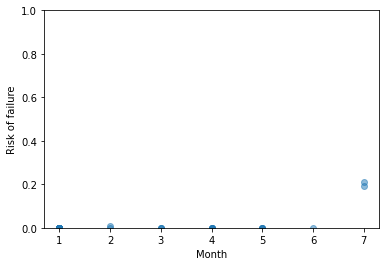

In [34]:
import numpy as np
import matplotlib.pyplot as plt

trace = conformance_on_time[3]['events']
y = [event['process_failure'] for event in trace]
x = [event['end_timestamp'].month for event in trace]

plt.scatter(x, y, alpha=0.5)
plt.ylim(0, 1);
plt.ylabel("Risk of failure")
plt.xlabel("Month")
plt.show()

In [19]:
conformance_on_time

[{'not_timely_activities': 19,
  'timely_activities': 26,
  'trace_time_duration': 199.27,
  'trace_time_divergence': 19.27,
  'time_accuracy': 0.58,
  'process_failure': 0.32,
  'events': [{'concept:name': 'Co-founder engagement',
    'start_timestamp': Timestamp('1970-01-01 01:03:00+0000', tz='UTC'),
    'end_timestamp': Timestamp('1970-01-02 01:57:35+0000', tz='UTC'),
    'time_divergence': 0.04,
    'process_failure': 0.0,
    'time_is_fit': False},
   {'concept:name': 'Co-founder termsheet - customization',
    'start_timestamp': Timestamp('1970-01-02 01:57:35+0000', tz='UTC'),
    'end_timestamp': Timestamp('1970-01-03 02:38:21+0000', tz='UTC'),
    'time_divergence': 0.03,
    'process_failure': 0.0,
    'time_is_fit': False},
   {'concept:name': 'Co-founder termsheet - signing',
    'start_timestamp': Timestamp('1970-01-03 02:38:21+0000', tz='UTC'),
    'end_timestamp': Timestamp('1970-01-04 06:10:00+0000', tz='UTC'),
    'time_divergence': 0.15,
    'process_failure': 0.0,
   

In [20]:
import numpy as np
average_results = {}
average_results['process_failure'] = np.mean([trace['process_failure'] for trace in conformance_on_time])
average_results['time_divergence'] = np.mean([trace['trace_time_divergence'] for trace in conformance_on_time])
average_results['trace_time_duration'] = np.mean([trace['trace_time_duration'] for trace in conformance_on_time])
average_results['number_of_activities'] = np.mean([len(trace['events'])  for trace in conformance_on_time])
average_results['time_accuracy'] = np.mean([trace['time_accuracy']  for trace in conformance_on_time])

In [21]:
average_results

{'process_failure': 0.2869642857142857,
 'time_divergence': 7.208035714285715,
 'trace_time_duration': 187.20803571428567,
 'number_of_activities': 43.392857142857146,
 'time_accuracy': 0.5035714285714287}